# Simulador de Localização de Centro de Distribuição (Magalu)

Este notebook compara os custos de abrir um novo Centro de Distribuição no **Recife (PE)** ou em **Salvador (BA)**, 
considerando:

1. **Custos imobiliários** (referência: relatório RB Investimentos, 2025).  
2. **Custos logísticos** — calculados com base nas distâncias rodoviárias até as cidades do Nordeste com >150 mil habitantes.  
3. **Demanda de entregas** proporcional à população de cada cidade.  

O objetivo é estimar qual localização gera o **menor custo total** e em quanto tempo o investimento se paga.


In [19]:
# ****ATENÇÃO**** 
# CASO JÁ TENHA PROCESSADO O CÁLCULO DAS DISTANCIAS ENTRE AS CIDADES
# E A TABELA ESTEJA SALVA: PULAR KERNELS INICIAIS (ATÉ A UTILIZAÇÃO DO OpenRouteService)


# Neste bloco, vamos utilizar a tabela de dados demográficos do IBGE2025 
# para filtrar as cidades do nordeste com >150k habitantes
# link: https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html
#(disponível em xls para download no link abaixo, mas aqui já convertida para .csv)
import numpy as np
import pandas as pd

df_pop = pd.read_csv("estimativa_dou_2025.csv", sep=",")
df_pop.columns = df_pop.columns.str.strip()  # tira espaços extras

df_pop.head()

,UF,COD_UF,COD_MUN,MUNICIPIO,POP
0,RO,11.0,15.0,Alta Floresta D'Oeste,22.787
1,RO,11.0,23.0,Ariquemes,109.170
2,RO,11.0,31.0,Cabixi,5.664
3,RO,11.0,49.0,Cacoal,98.280
4,RO,11.0,56.0,Cerejeiras,16.966


In [21]:
# Alterando nomes das colunas e passando informação sobre a população para tipo integer
# Remove espaços no nome das colunas
df_pop.columns = df_pop.columns.str.strip()

# Converte para string, limpa pontos e remove NaN
df_pop["POP"] = (
    df_pop["POP"]
    .astype(str)                # garante string
    .str.replace(".", "", regex=False)  # tira pontos
    .str.strip()                # remove espaços extras
)

# Remove linhas inválidas (nan, vazio, etc.)
df_pop = df_pop[df_pop["POP"].str.isnumeric()].copy()

# Converte para inteiro
df_pop["POP"] = df_pop["POP"].astype(int)

# Renomeia colunas
df_pop = df_pop.rename(columns={
    "UF": "uf",
    "COD_UF": "cod_uf",
    "COD_MUN": "cod_municipio",
    "MUNICIPIO": "municipio",
    "POP": "populacao"
})

df_pop.head(), df_pop.dtypes

(   uf  cod_uf  cod_municipio              municipio  populacao
 0  RO    11.0           15.0  Alta Floresta D'Oeste      22787
 1  RO    11.0           23.0              Ariquemes     109170
 2  RO    11.0           31.0                 Cabixi       5664
 3  RO    11.0           49.0                 Cacoal      98280
 4  RO    11.0           56.0             Cerejeiras      16966,
 uf                object
 cod_uf           float64
 cod_municipio    float64
 municipio         object
 populacao          int64
 dtype: object)

In [22]:
# Aplica filtro para cidades do nordeste com >150k hab
ufs_ne = ["MA","PI","CE","RN","PB","PE","AL","SE","BA"]
df_ne = df_pop[df_pop["uf"].isin(ufs_ne)].copy()
df_ne150k = df_ne[df_ne["populacao"] > 150_000].reset_index(drop=True)

print("Total de cidades NE >150k habitantes:", len(df_ne150k))
df_ne150k.head()


Total de cidades NE >150k habitantes: 45


,uf,cod_uf,cod_municipio,municipio,populacao
0,MA,21.0,3000.0,Caxias,163546
1,MA,21.0,5302.0,Imperatriz,285806
2,MA,21.0,7506.0,Paço do Lumiar,153158
3,MA,21.0,11201.0,São José de Ribamar,259164
4,MA,21.0,11300.0,São Luís,1089215


In [24]:
# agora vamos adicionar as coordenadas dessas cidades para posteriormente calcular as distancias
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="magalu_simulador")

latitudes, longitudes = [], []

for cidade, uf in zip(df_ne150k["municipio"], df_ne150k["uf"]):
    try:
        location = geolocator.geocode(f"{cidade}, {uf}, Brasil")
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except Exception as e:
        print(f"Erro ao geocodificar {cidade}-{uf}: {e}")
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)  # respeitar limite do Nominatim

df_ne150k["lat"] = latitudes
df_ne150k["lon"] = longitudes

df_ne150k.head()


,uf,cod_uf,cod_municipio,municipio,populacao,lat,lon
0,MA,21.0,3000.0,Caxias,163546,-4.865420,-43.353664
1,MA,21.0,5302.0,Imperatriz,285806,-5.526928,-47.478115
2,MA,21.0,7506.0,Paço do Lumiar,153158,-2.532906,-44.159197
3,MA,21.0,11201.0,São José de Ribamar,259164,-2.560912,-44.055951
4,MA,21.0,11300.0,São Luís,1089215,-2.529526,-44.296394


In [25]:
# Salva o data frame em um novo arquivo
df_ne150k.to_csv("cidades_ne150k.csv", index=False)

In [26]:
# agora vamos calcular as distancias mais próximas pelas rodovias disponíveis utilizando o OpenRouteService
# Para ter uma chave para a API, é necessário ter uma conta no https://openrouteservice.org/ 
import requests
import time

# Defina sua chave da API ORS
ORS_API_KEY = "ADD YOUR API KEY HERE"

# Coordenadas das origens
coord_origens = {
    "recife":    (-34.8770, -8.0476),   # (lon, lat)
    "salvador":  (-38.5014, -12.9714),
}

def ors_distance(lon1, lat1, lon2, lat2, retries=3, sleep=1.5):
    url = "https://api.openrouteservice.org/v2/directions/driving-car"
    headers = {"Authorization": ORS_API_KEY, "Content-Type": "application/json"}
    body = {"coordinates": [[lon1, lat1], [lon2, lat2]]}
    for attempt in range(retries):
        try:
            r = requests.post(url, json=body, headers=headers, timeout=30)
            js = r.json()
            if "routes" in js:
                dist_km = js["routes"][0]["summary"]["distance"] / 1000
                tempo_h = js["routes"][0]["summary"]["duration"] / 3600
                return dist_km, tempo_h
        except Exception as e:
            print(f"Tentativa {attempt+1} falhou: {e}")
            time.sleep(sleep)
    return None, None

# Criar colunas de distância/tempo para cada origem
for origem, (olon, olat) in coord_origens.items():
    dists, tempos = [], []
    for _, row in df_ne150k.iterrows():
        if abs(row["lat"] - olat) < 1e-3 and abs(row["lon"] - olon) < 1e-3:
            dists.append(0.0)
            tempos.append(0.0)
        else:
            d, t = ors_distance(olon, olat, row["lon"], row["lat"])
            dists.append(d)
            tempos.append(t)
            time.sleep(0.2)  # respeitar API
    df_ne150k[f"dist_{origem}_km"] = dists
    df_ne150k[f"tempo_{origem}_h"] = tempos

df_ne150k.head()


,uf,cod_uf,cod_municipio,municipio,populacao,lat,lon,dist_recife_km,tempo_recife_h,dist_salvador_km,tempo_salvador_h
0,MA,21.0,3000.0,Caxias,163546,-4.865420,-43.353664,1194.9111,14.601389,1218.7351,15.905194
1,MA,21.0,5302.0,Imperatriz,285806,-5.526928,-47.478115,1705.1704,22.250833,1728.9945,23.554611
2,MA,21.0,7506.0,Paço do Lumiar,153158,-2.532906,-44.159197,1561.7015,19.905056,1585.5255,21.208833
3,MA,21.0,11201.0,São José de Ribamar,259164,-2.560912,-44.055951,1573.1005,20.072694,1596.9245,21.376472
4,MA,21.0,11300.0,São Luís,1089215,-2.529526,-44.296394,1557.7181,19.800917,1581.5422,21.104722


In [27]:
# salvar tabela:
df_ne150k.to_csv("cidades_ne150k.csv", index=False)

In [28]:
# SE A TABELA COM AS DISTANCIAS ENTRE AS CIDADES JÁ ESTIVER SALVA
# RODAR A PARTIR DAQUI! 
import pandas as pd

df_ne150k = pd.read_csv('cidades_ne150k.csv')
df_ne150k.head()

,uf,cod_uf,cod_municipio,municipio,populacao,lat,lon,dist_recife_km,tempo_recife_h,dist_salvador_km,tempo_salvador_h
0,MA,21.0,3000.0,Caxias,163546,-4.865420,-43.353664,1194.9111,14.601389,1218.7351,15.905194
1,MA,21.0,5302.0,Imperatriz,285806,-5.526928,-47.478115,1705.1704,22.250833,1728.9945,23.554611
2,MA,21.0,7506.0,Paço do Lumiar,153158,-2.532906,-44.159197,1561.7015,19.905056,1585.5255,21.208833
3,MA,21.0,11201.0,São José de Ribamar,259164,-2.560912,-44.055951,1573.1005,20.072694,1596.9245,21.376472
4,MA,21.0,11300.0,São Luís,1089215,-2.529526,-44.296394,1557.7181,19.800917,1581.5422,21.104722


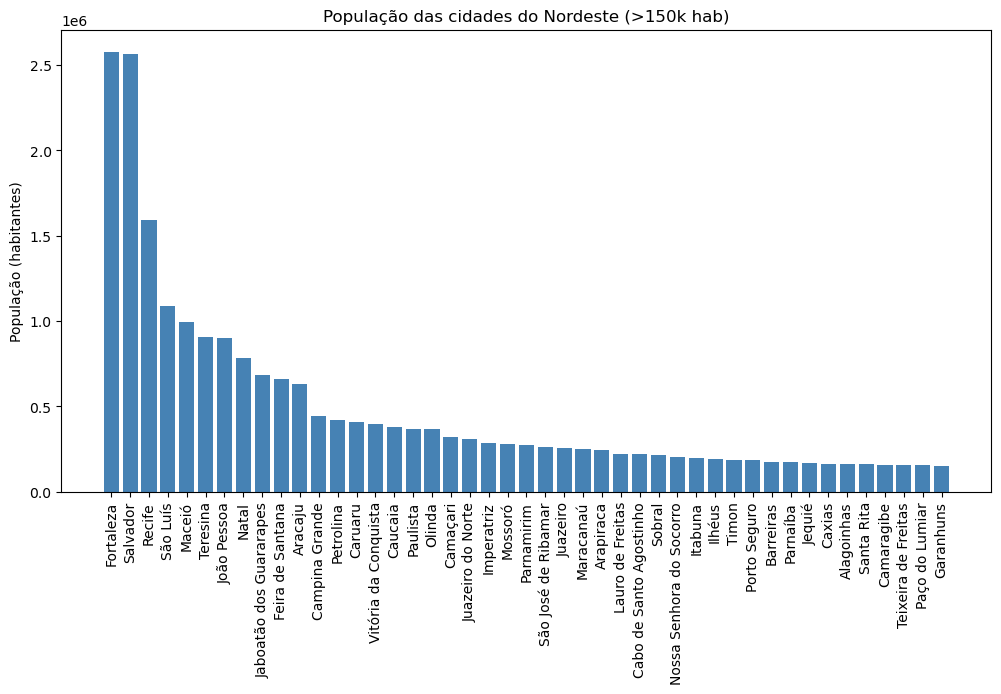

In [29]:
# Alguns plots para verificar dados obtidos até aqui
import matplotlib.pyplot as plt


# histograma: populações
df_ne150k_sorted = df_ne150k.sort_values("populacao", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(df_ne150k_sorted["municipio"], df_ne150k_sorted["populacao"], color="steelblue")
plt.xticks(rotation=90)
plt.ylabel("População (habitantes)")
plt.title("População das cidades do Nordeste (>150k hab)")
plt.show()


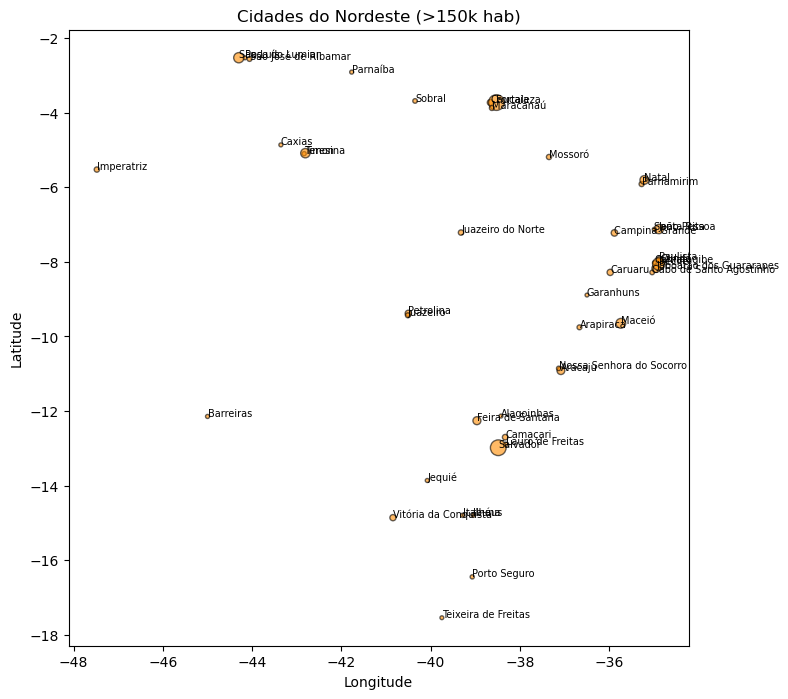

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(df_ne150k["lon"], df_ne150k["lat"], s=df_ne150k["populacao"]/20000, alpha=0.6, color="darkorange", edgecolor="k")

for _, row in df_ne150k.iterrows():
    plt.text(row["lon"], row["lat"], row["municipio"], fontsize=7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cidades do Nordeste (>150k hab)")
plt.show()


In [31]:
# Mapa interativo com a posição das cidades.
# tamanho do marcador é proporcional às população

import folium

# Centralizar o mapa no NE
m = folium.Map(location=[-9, -39], zoom_start=5)

for _, row in df_ne150k.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["populacao"]/200000,  # escala do tamanho
        popup=f"{row['municipio']} ({row['populacao']:,} hab)",
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(m)

m.save("mapa_cidades_ne150k.html")
m

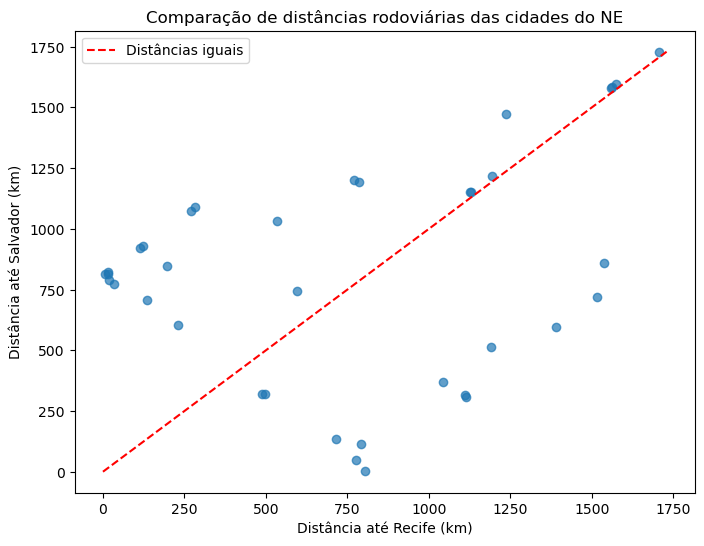

In [32]:
# Distancias recife vs. salvador 

plt.figure(figsize=(8,6))
plt.scatter(df_ne150k["dist_recife_km"], df_ne150k["dist_salvador_km"], alpha=0.7)

# Linha de referência (onde distâncias seriam iguais)
max_val = max(df_ne150k["dist_recife_km"].max(), df_ne150k["dist_salvador_km"].max())
plt.plot([0, max_val], [0, max_val], "r--", label="Distâncias iguais")

plt.xlabel("Distância até Recife (km)")
plt.ylabel("Distância até Salvador (km)")
plt.title("Comparação de distâncias rodoviárias das cidades do NE")
plt.legend()
plt.show()


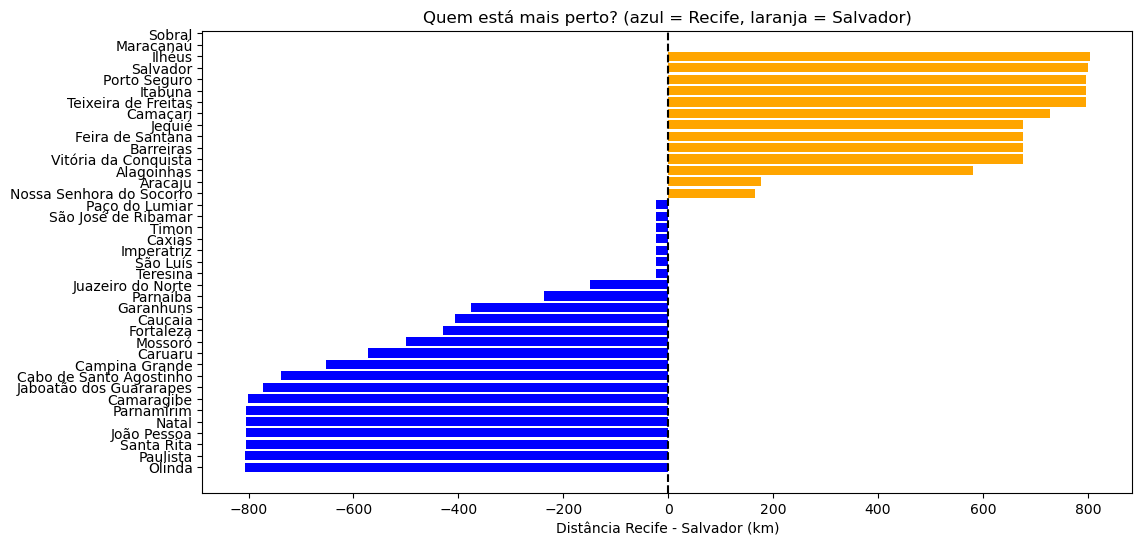

In [33]:
# Distancia de recife *menos* distancia de salvador
# qual pólo está mais próximo?
df_ne150k["delta_km"] = df_ne150k["dist_recife_km"] - df_ne150k["dist_salvador_km"]

df_sorted = df_ne150k.sort_values("delta_km")

plt.figure(figsize=(12,6))
plt.barh(df_sorted["municipio"], df_sorted["delta_km"], color=df_sorted["delta_km"].apply(lambda x: "blue" if x < 0 else "orange"))
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Distância Recife - Salvador (km)")
plt.title("Quem está mais perto? (azul = Recife, laranja = Salvador)")
plt.show()


## Cálculos logísticos

- **Para cidades ≠ origem:**  
  `custo = entregas × distância_rodoviária × custo_km`

- **Para a cidade da origem:**  
  `custo = entregas × km_intra_urbano (15 km) × custo_km`

---

**Ponderação pelas populações:**  
Os cálculos de entregas serão ponderados pelo número de habitantes de cada cidade.  
Por exemplo, se tivermos **1000 entregas** em um dado período, esse número será dividido proporcionalmente entre todas as cidades do Nordeste consideradas nesta análise.

O preço imobiliário de cada cidade (Salvador ou Recife) de galpões logísticos também será levado em consideração para avaliarmos o payback.

---

**Parâmetros iniciais (ajustáveis conforme a necessidade):**
- `n_entregas`: número total de entregas no período
- `custo_km`: custo médio por km por entrega (Reais/km)
- `km_intra_urbano`: distância média para last-mile na cidade da origem (km)
- `preco_m2_recife`: preço médio por m² em Recife (Reais/m²) - retirado do relatório RB investimentos para galpões logísticos (https://www.rbinvestimentos.com/wp-content/uploads/2025/05/Galpoes-Logisticos-1.pdf)
- `preco_m2_salvador`: preço médio por m² em Salvador (Reais/m²) - retirado do relatório RB investimentos para galpões logísticos (https://www.rbinvestimentos.com/wp-content/uploads/2025/05/Galpoes-Logisticos-1.pdf)
- `cd_area_m2`: área total do centro de distribuição (m²)



,origem,custo_logistico_mes,custo_fixo_imobiliario_mes,custo_total_mes,dist_media_ponderada_km
0,Recife,"R$ 36,511,716","R$ 205,000","R$ 36,716,716",730.234320
1,Salvador,"R$ 39,984,388","R$ 295,000","R$ 40,279,388",798.215613



 Número de entregas no mês: 50,000

💰 Diferença mensal (Salvador - Recife): R$ 3,562,672
📉 Economia percentual ao escolher Recife: 8.84%


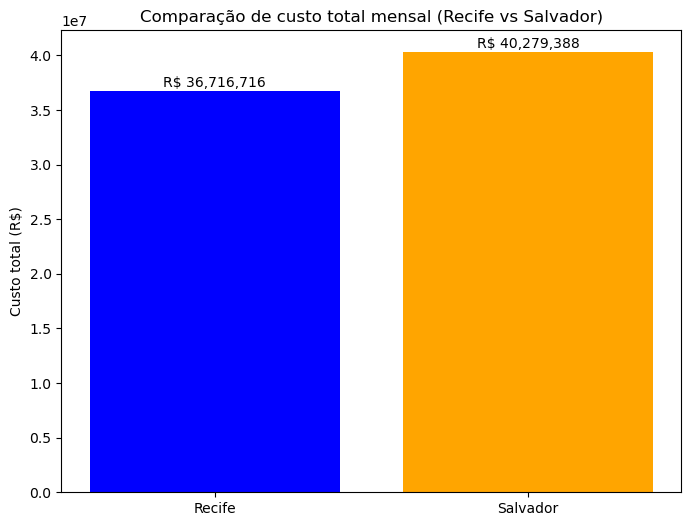

In [43]:
import numpy as np
import pandas as pd

# -------------------------
# Parâmetros escolhidos pelo usuário
# -------------------------
n_entregas  = 50_000   # total de entregas/mês (ajuste livre)
custo_km    = 1.00      # R$/km por entrega (combustível + motorista + manutenção)
km_intra_urbano = 15.0  # km médios por entrega dentro da cidade da origem (last-mile urbano)

# Custos imobiliários (RB Investimentos, CD de 10.000 m²)
cd_area_m2 = 10_000
preco_m2_recife   = 20.5   # R$/m²
preco_m2_salvador = 29.5   # R$/m²
custo_fix_recife   = cd_area_m2 * preco_m2_recife
custo_fix_salvador = cd_area_m2 * preco_m2_salvador

# -------------------------
# Preparos
# -------------------------
df = df_ne150k.copy()

# Segurança: se houver distâncias faltantes, descarta para não quebrar a simulação
cols_need = ["dist_recife_km","dist_salvador_km","populacao","municipio","uf"]
df = df.dropna(subset=cols_need).reset_index(drop=True)

# Total populacional para ponderação de demanda
total_pop = df["populacao"].sum()

def simular_para_origem(df_cidades, origem_nome, coluna_dist_km, custo_fixo_origem,
                        n_entregas, custo_km, km_intra_urbano):
    """
    origem_nome: "Recife" ou "Salvador" (como aparece em df['municipio'])
    coluna_dist_km: "dist_recife_km" ou "dist_salvador_km"
    """
    df_sim = df_cidades.copy()

    # entregas proporcionais à população
    df_sim["entregas"] = n_entregas * (df_sim["populacao"] / total_pop)

    # distância ajustada: se a cidade == origem, usar km_intra_urbano; senão, usar a distância rodoviária
    df_sim["dist_ajustada_km"] = np.where(
        df_sim["municipio"].str.lower() == origem_nome.lower(),
        km_intra_urbano,
        df_sim[coluna_dist_km]
    )

    # custo logístico por cidade
    df_sim["custo_logistico"] = df_sim["entregas"] * df_sim["dist_ajustada_km"] * custo_km

    custo_log_total = df_sim["custo_logistico"].sum()
    custo_total = custo_log_total + custo_fixo_origem

    # métricas auxiliares úteis
    dist_media_ponderada = (df_sim[coluna_dist_km] * df_sim["populacao"]).sum() / df_sim["populacao"].sum()
    dist_media_ponderada = float(dist_media_ponderada)

    resumo = {
        "origem": origem_nome,
        "custo_logistico": custo_log_total,
        "custo_fixo_imobiliario": custo_fixo_origem,
        "custo_total": custo_total,
        "dist_media_ponderada_km": dist_media_ponderada,
        "n_entregas": n_entregas,
        "custo_km": custo_km,
        "km_intra_urbano": km_intra_urbano,
    }
    return resumo, df_sim[["municipio","uf","populacao","entregas","dist_ajustada_km","custo_logistico"]]

# -------------------------
# Rodar simulação para Recife e para Salvador
# -------------------------
res_rec, det_rec = simular_para_origem(
    df, "Recife", "dist_recife_km", custo_fix_recife,
    n_entregas, custo_km, km_intra_urbano
)

res_sal, det_sal = simular_para_origem(
    df, "Salvador", "dist_salvador_km", custo_fix_salvador,
    n_entregas, custo_km, km_intra_urbano
)

# Comparativo em DataFrame
comparativo = pd.DataFrame([res_rec, res_sal])

# Calcular diferença e economia percentual
custo_recife = res_rec["custo_total"]
custo_salvador = res_sal["custo_total"]

diff_mensal = custo_salvador - custo_recife
economia_pct = (diff_mensal / custo_salvador) * 100

comparativo["custo_total_mes"] = comparativo["custo_total"].map(lambda x: f"R$ {x:,.0f}")
comparativo["custo_logistico_mes"] = comparativo["custo_logistico"].map(lambda x: f"R$ {x:,.0f}")
comparativo["custo_fixo_imobiliario_mes"] = comparativo["custo_fixo_imobiliario"].map(lambda x: f"R$ {x:,.0f}")

display(comparativo[[
    "origem",
    "custo_logistico_mes",
    "custo_fixo_imobiliario_mes",
    "custo_total_mes",
    "dist_media_ponderada_km"
]])

print(f"\n Número de entregas no mês: {n_entregas:,.0f}")
print(f"\n💰 Diferença mensal (Salvador - Recife): R$ {diff_mensal:,.0f}")
print(f"📉 Economia percentual ao escolher Recife: {economia_pct:.2f}%")

# --- Gráfico de barras
plt.figure(figsize=(8,6))
plt.bar(["Recife","Salvador"], [custo_recife, custo_salvador], color=["blue","orange"])
plt.ylabel("Custo total (R$)")
plt.title("Comparação de custo total mensal (Recife vs Salvador)")

# valores acima das barras
for i, v in enumerate([custo_recife, custo_salvador]):
    plt.text(i, v + v*0.01, f"R$ {v:,.0f}", ha="center", fontsize=10)

plt.show()

# As tabelas detalhadas (se quiser inspecionar por cidade)
# det_rec.head(), det_sal.head()


## Interpretação dos Resultados

Após rodar a simulação, o notebook gera um comparativo entre **Recife** e **Salvador** como locais potenciais para o novo Centro de Distribuição (CD).

### Saídas principais:
- **Custo logístico total**: resultado do transporte rodoviário entre a origem e as demais cidades do Nordeste (ponderado pela população de cada destino).
- **Custo fixo imobiliário**: custo mensal de aluguel do CD, considerando os valores de referência da RB Investimentos (R$/m²).
- **Custo total**: soma do custo logístico e do custo fixo imobiliário.
- **Distância média ponderada**: distância média das rotas Recife/Salvador até as cidades do Nordeste, levando em conta o peso demográfico de cada cidade.

### Como interpretar:
- Se o **custo total em Recife < Salvador**, então **Recife é mais vantajoso** no cenário analisado (e vice-versa).
- A coluna de **diferença mensal** mostra a economia estimada por mês.
- A **economia percentual** permite entender a magnitude da vantagem (ex.: “Recife é 18% mais barato que Salvador”).
- A partir da economia mensal, é possível calcular o **payback**:  
  - Se a escolha mais cara tiver alguma vantagem estratégica (estoque maior, incentivos fiscais, etc.), o payback mostra em quanto tempo esse custo adicional seria compensado ou se justifica.

### Observação importante:
Este modelo é **paramétrico** — ou seja, os resultados mudam se alterarmos:
- `n_entregas` (escala da operação),
- `custo_km` (variação no custo do transporte),
- `km_intra_urbano` (last-mile nas cidades de origem),
- ou o **preço/m²** considerado para cada CD.

Assim, o notebook pode ser usado para **testar diferentes cenários** e apoiar a tomada de decisão com base em dados.
